In [1]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


### Data preparation

#### Reading data

In [3]:
df = pd.read_csv('../data/emotions/emotions.csv')

In [4]:
df['category'] = df['category'].str.strip()

In [5]:
df.shape

(35887, 2307)

In [6]:
train = df.loc[df.category == 'Training',:]
valid = df.loc[df.category == 'PublicTest',:]
test  = df.loc[df.category == 'PrivateTest',:]

In [7]:
train.head(5)

,Unnamed: 0,y,0,1,2,3,4,5,6,7,...,2295,2296,2297,2298,2299,2300,2301,2302,2303,category
0,0,0,70,80,82,72,58,58,60,63,...,182,183,136,106,116,95,106,109,82,Training
1,1,0,151,150,147,155,148,133,111,140,...,108,95,108,102,67,171,193,183,184,Training
2,2,2,231,212,156,164,174,138,161,173,...,138,152,122,114,101,97,88,110,152,Training
3,3,4,24,32,36,30,32,23,19,20,...,126,132,132,133,136,139,142,143,142,Training
4,4,6,4,0,0,0,0,0,0,0,...,34,31,31,31,27,31,30,29,30,Training


In [10]:
X_train = np.array(train.iloc[:, 2:2306])
y_train = np.array(train.loc[:, ['y']])

print(X_train.shape)
print(y_train.shape)

(28709, 2304)
(28709, 1)


In [11]:
X_val = np.array(valid.iloc[:, 2:2306])
y_val = np.array(valid.loc[:, ['y']])

print(X_val.shape)
print(y_val.shape)

(3589, 2304)
(3589, 1)


In [12]:
X_test = np.array(test.iloc[:, 2:2306])
y_test = np.array(test.loc[:, ['y']])

print(X_test.shape)
print(y_test.shape)

(3589, 2304)
(3589, 1)


#### Define mapping from labels to their names

In [13]:
mapping = {
    0: 'Angry', 
    1: 'Disgust', 
    2: 'Fear', 
    3: 'Happy', 
    4: 'Sad', 
    5: 'Surprise', 
    6: 'Neutral'   
}

#### Display some random images

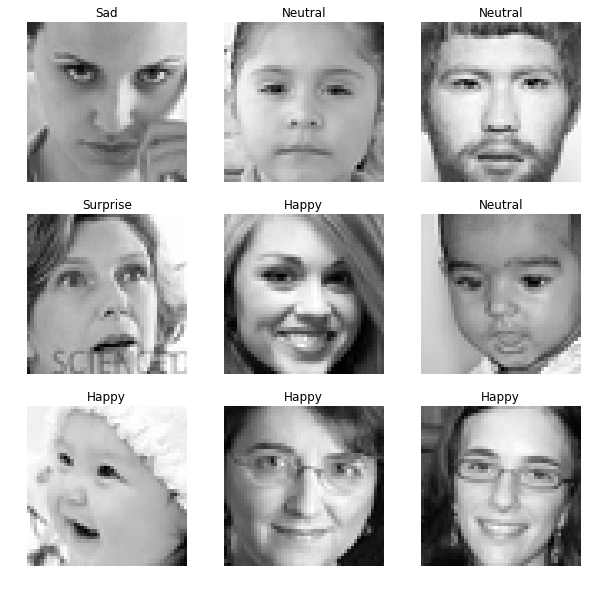

In [15]:
np.random.seed(1)

fig = plt.figure(figsize=(10, 10))

rows = 3
cols = 3

for i in range(1, rows * cols + 1):
    idx = np.random.randint(1, len(X_train))
    
    fig.add_subplot(rows, cols, i)
    plt.imshow(X_train[idx].reshape((48,48)), cmap = 'gray')
    plt.title(mapping[y_train[idx][0]])
    plt.axis('off')
plt.show()

In [16]:
y_train = keras.utils.to_categorical(y_train, 7)
y_train.shape

(28709, 7)

In [17]:
y_val = keras.utils.to_categorical(y_val, 7)
y_val.shape

(3589, 7)

In [55]:
y_test = keras.utils.to_categorical(y_test, 7)
y_test.shape

(3589, 7)

### Baseline CNN Model

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import optimizers

from keras.models import model_from_json

from keras.metrics import categorical_accuracy

np.random.seed(100)

#### Reshape samples

In [29]:
X_train_r = X_train.reshape((len(X_train), 48, 48, 1))
X_val_r   = X_val.reshape((len(X_val), 48, 48, 1))
X_test_r   = X_test.reshape((len(X_test), 48, 48, 1))

#### Normalize data

In [30]:
X_train_r = X_train_r / 255

In [31]:
X_val_r = X_val_r / 255

In [32]:
X_test_r = X_test_r / 255

#### Define the model

In [23]:
model = Sequential()

model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[categorical_accuracy])

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 128)       512       
__________

#### Load weights of the pretrained model (since on laptop without GPU it takes nearly 8 hours to train it)

In [181]:
model.load_weights('../models/weights/complex_20_cc.h5')

In [182]:
model.fit(X_train_r, y_train, batch_size=32, epochs=3, validation_data=(X_val_r, y_val))

Train on 28709 samples, validate on 3589 samples
Epoch 1/3
28709/28709 [==============================] - 1270s 44ms/step - loss: 0.2413 - categorical_accuracy: 0.9145 - val_loss: 1.7545 - val_categorical_accuracy: 0.6119
Epoch 2/3
28709/28709 [==============================] - 1156s 40ms/step - loss: 0.2483 - categorical_accuracy: 0.9121 - val_loss: 1.5555 - val_categorical_accuracy: 0.6152
Epoch 3/3
28709/28709 [==============================] - 1145s 40ms/step - loss: 0.2404 - categorical_accuracy: 0.9157 - val_loss: 1.4941 - val_categorical_accuracy: 0.6247


#### Code to save the trained model to disc

In [187]:
model.save_weights('../models/weights/complex_20_cc_2.h5')

In [195]:
model_json = model.to_json()

In [196]:
with open("../models/model_deep.json", "w") as json_file:
    json_file.write(model_json)

#### Iteration

In [26]:
def read_model_from_disk(model: str, weights: str):
    
    json_file = open(model, 'r')
    
    loaded_model = json_file.read()
    
    model = model_from_json(loaded_model)
    
    model.load_weights(weights)
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[categorical_accuracy])
    
    return model

In [33]:
model_saved = read_model_from_disk(model='../models/model_deep.json', weights='../models/weights/complex_20_cc_2.h5')

### Evaluations

In [34]:
model_saved.evaluate(X_test_r, y = y_test, verbose=1)

3589/3589 [==============================] - 38s 11ms/step


[1.4520415713708026, 0.632488158269658]

### Experiments

In [46]:
from sklearn.metrics import confusion_matrix

During the data analysis stage of our project we understood that the primary weakness of this dataset is its inbalanceness. We haven't tackled this issue yet (plan to do it in the next iteration), but we understood that dealing with it is a major part of this particular problem solution.

Let's take a look on the accuracy of prediction of separate classes of emotions.

In [62]:
y = pd.DataFrame(np.argmax(y_test, axis = 1), columns=['true'])

In [63]:
y['pred'] = model_saved.predict_classes(X_test_r)

In [66]:
y['true'] = y['true'].map(mapping)

In [68]:
y['pred'] = y['pred'].map(mapping)

In [100]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontdict = {'fontsize': 20})
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

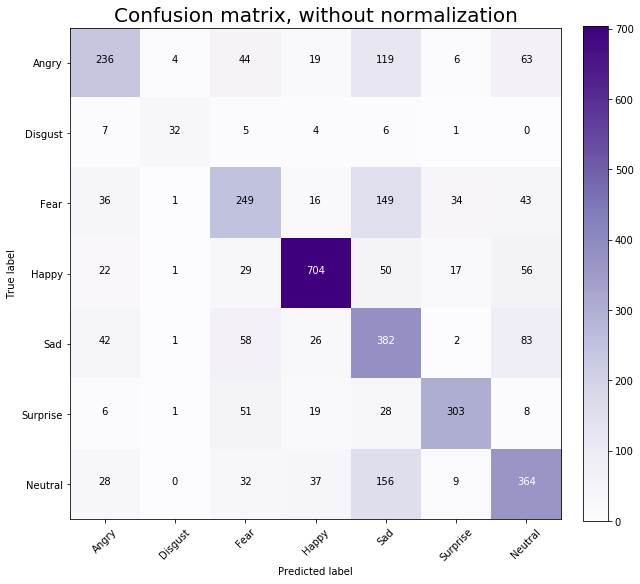

In [111]:
cnf_matrix = confusion_matrix(y['true'], y['pred'],
                              labels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])

np.set_printoptions(precision=2)


plt.figure(figsize=(9, 9))
plot_confusion_matrix(cnf_matrix, 
                      classes=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'],
                      title='Confusion matrix, without normalization', cmap = 'Purples')

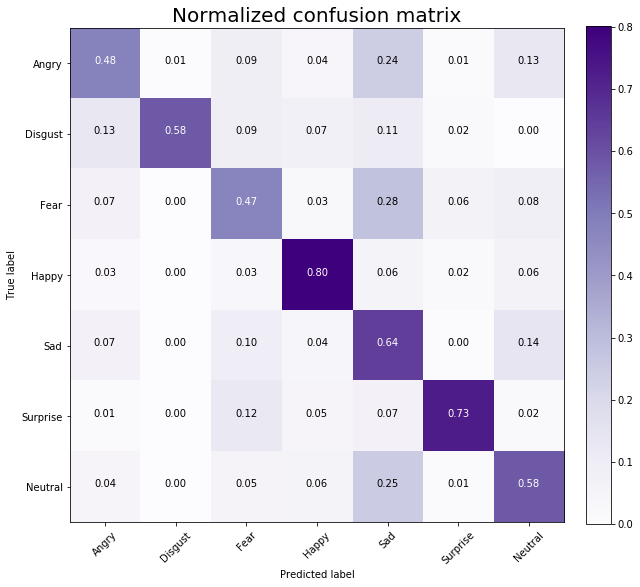

In [112]:
plt.figure(figsize=(9, 9))
plot_confusion_matrix(cnf_matrix, 
                      classes=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'],
                      normalize=True,
                      title='Normalized confusion matrix', cmap = 'Purples')

Looks really funny, because we've got very unexpected results. `Disgust` emotion, while being extremely underepresented is our dataset is not the one that suffers most from misclassification.

It is `Angry` and `Fear`, that model most offen treats as other facial expression.